# 앙상블: Boosting

1. XGboost를 적용해본다.
2. 다른 알고리즘들과 성능을 비교해본다.

---------------------------


## 1.데이터 준비

### (1) 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### (2) 데이터 업로드

In [ ]:
# mobile data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv"
data = pd.read_csv(path)
data.drop(['id', 'REPORTED_USAGE_LEVEL','OVER_15MINS_CALLS_PER_MONTH'], axis = 1, inplace = True)
data.rename(columns = {'HANDSET_PRICE':'H_PRICE',
                       'AVERAGE_CALL_DURATION':'DURATION',
                       'REPORTED_SATISFACTION':'SATISFACTION',
                       'CONSIDERING_CHANGE_OF_PLAN':'CHANGE'}
            , inplace = True)
data['CHURN'] = np.where(data['CHURN'] == 'LEAVE', 1, 0)  # XGBoost는 Label이 1,0 이어야 함 (y 정수 인코딩!!!!!)
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,H_PRICE,DURATION,SATISFACTION,CHANGE,CHURN
0,0,31953,0,6,313378,161,4,unsat,no,0
1,1,36147,0,13,800586,244,6,unsat,considering,0
2,1,27273,230,0,305049,201,15,unsat,perhaps,0
3,0,120070,38,33,788235,780,2,unsat,considering,1
4,1,29215,208,85,224784,241,1,very_unsat,never_thought,0


|변수 명|내용|구분|
|----|----|----|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


In [ ]:
# 데이터분할1
target = 'CHURN'
x = data.drop(target, axis=1)
y = data.loc[:, target]

# 가변수화
dumm_cols = ['SATISFACTION','CHANGE']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

# 데이터 분할2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.5, random_state = 20)

## 2.모델링

* Boosting 원리를 이용한 알고리즘 : XGB, LightGBM

In [ ]:
# 1) 함수 불러오기
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import *

In [ ]:
# 2) 모델 선언
model = XGBClassifier(n_estimators = 5, max_depth = 3)

In [ ]:
# 3) 학습
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 4) 예측
pred = model.predict(x_val)

In [ ]:
# 5) 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      5105
           1       0.70      0.64      0.67      4895

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



## 3.XGBoost에 대해서...

### 1) 모델 시각화

xgboost 자체 plot_tree 함수를 제공합니다.

* plot_tree(model, num_trees = 0)
    * num_trees : 전체 트리 5개짜리 모델이므로 각각 0~4까지 인덱스로 조회해 볼 수 있다.

In [ ]:
plt.rcParams['figure.figsize'] = 20,20  # 그래프 크기 설정

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


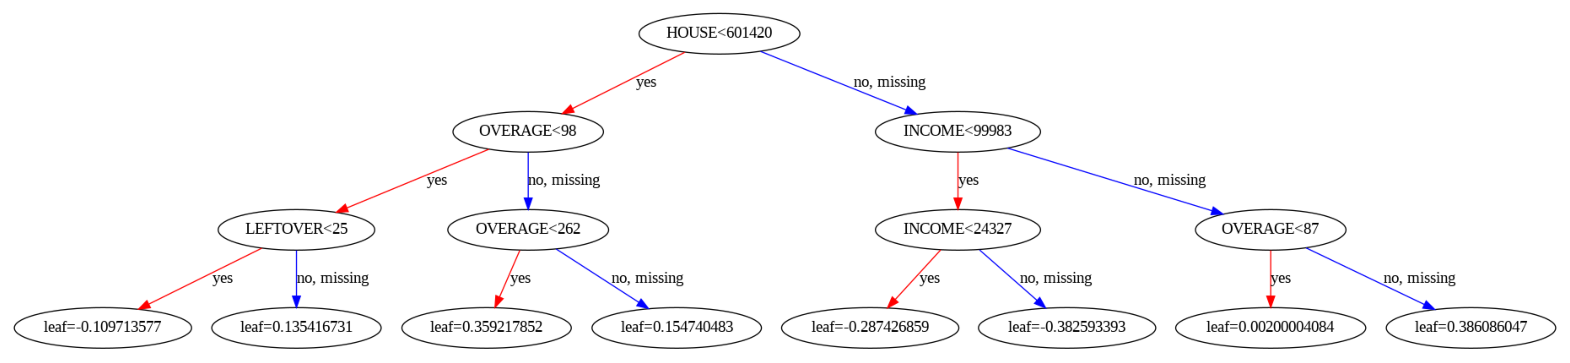

In [ ]:
plot_tree(model, num_trees = 0)
plt.show()

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


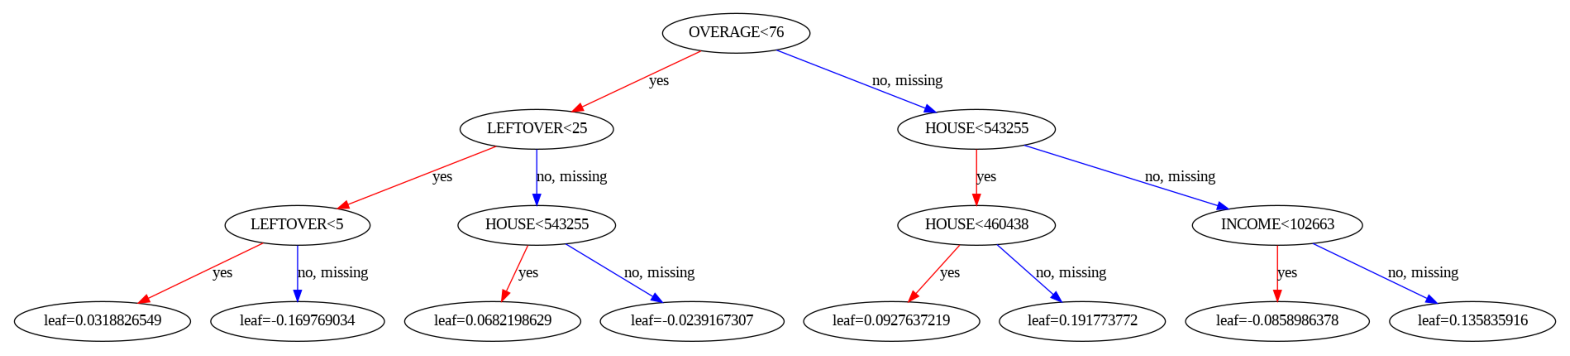

In [ ]:
plot_tree(model, num_trees = 4)
plt.show()

### 2) 변수 중요도

In [ ]:
# 변수 중요도
print(x_train.columns)
print(model.feature_importances_)

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'H_PRICE',
       'DURATION', 'SATISFACTION_sat', 'SATISFACTION_unsat',
       'SATISFACTION_very_sat', 'SATISFACTION_very_unsat',
       'CHANGE_considering', 'CHANGE_never_thought', 'CHANGE_no',
       'CHANGE_perhaps'],
      dtype='object')
[0.         0.33398166 0.25514588 0.13050784 0.27461636 0.
 0.00574822 0.         0.         0.         0.         0.
 0.         0.         0.        ]


* 변수중요도 그래프 그리기 함수 만들기

In [ ]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

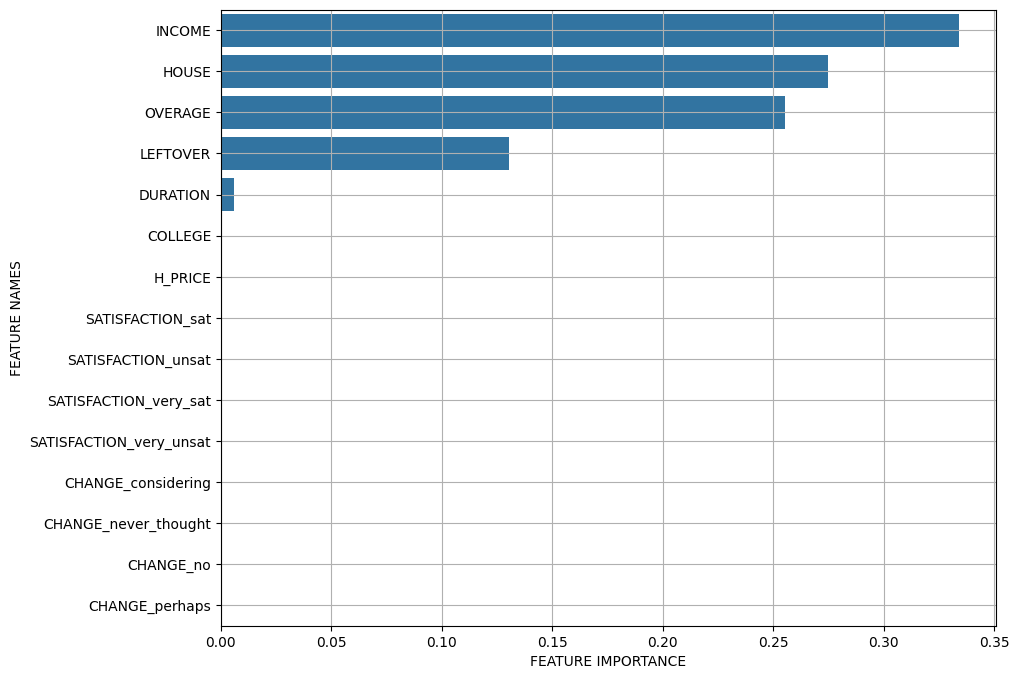

In [ ]:
plot_feature_importance(model.feature_importances_, x_train.columns)

## 4.하이퍼파라미터 변화에 따른 성능 추세

### (1) n_estimators
* 1~150까지 증가시켜가며 성능 추세 살펴보기

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_param = {'n_estimators':range(1,100,2)}
model = XGBClassifier()
model_gs = GridSearchCV(model, grid_param, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'n_estimators': range(1, 100, 2)})

In [ ]:
result = pd.DataFrame(model_gs.cv_results_)

In [ ]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_n_estimators','mean_test_score']]
temp.head()

,param_n_estimators,mean_test_score
0,1,0.6932
1,3,0.6955
2,5,0.6955
3,7,0.6969
4,9,0.6938


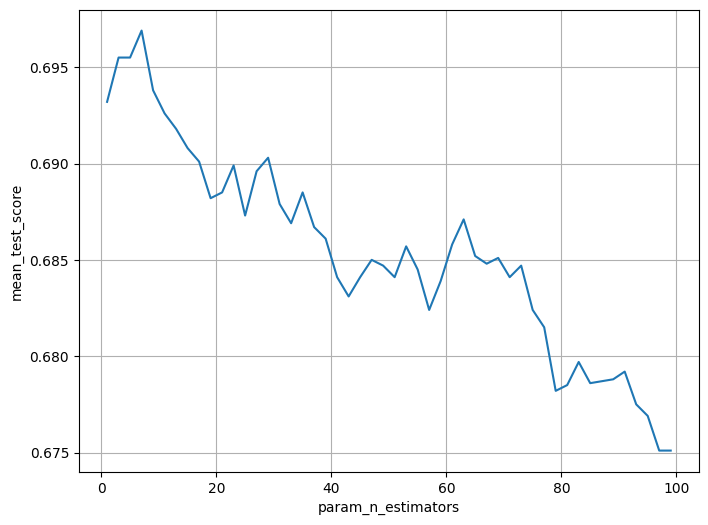

In [ ]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_n_estimators', y = 'mean_test_score', data = temp )
plt.grid()
plt.show()

### (2) learning rate
* 0.01 ~ 1까지 증가시켜가며 성능 추세 살펴보기

In [ ]:
grid_param = {'learning_rate': np.linspace(0.02, 1, 50)}
model = XGBClassifier(n_estimators=7)
model_gs = GridSearchCV(model, grid_param, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     multi_strategy=None, n_estimators=7,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])})

In [ ]:
result = pd.DataFrame(model_gs.cv_results_)

In [ ]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_learning_rate','mean_test_score']]
temp.head()

,param_learning_rate,mean_test_score
0,0.02,0.6967
1,0.04,0.6986
2,0.06,0.6985
3,0.08,0.6976
4,0.10,0.6955


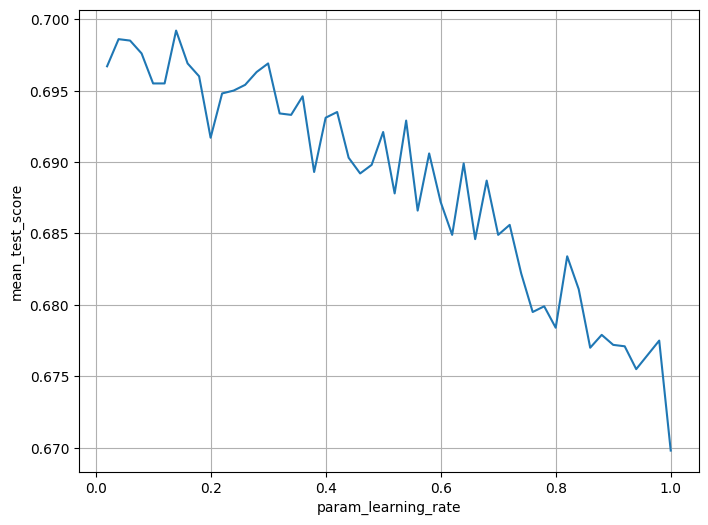

In [ ]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_learning_rate', y = 'mean_test_score', data = temp )
plt.grid()
plt.show()

### (3) n_estimators + learning rate
* 이번에는 두 하이퍼파라미터를 동시에 조절하며 추세를 살펴보겠습니다.
* n_estimators : 10, 50, 100
* learning_rate : 0.01 ~ 0.3까지 0.01씩 증가

In [ ]:
grid_param = {'learning_rate':np.linspace(0.01,0.3,30),
              'n_estimators':[3,7,15,20,30]}
model = XGBClassifier()
model_gs = GridSearchCV(model, grid_param, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ]),
                         'n_estimators': [3, 7, 15, 20, 30]})

In [ ]:
result = pd.DataFrame(model_gs.cv_results_)

In [ ]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_n_estimators', 'param_learning_rate','mean_test_score']]
temp.head()

,param_n_estimators,param_learning_rate,mean_test_score
0,3,0.01,0.6641
1,7,0.01,0.6920
2,15,0.01,0.6975
3,20,0.01,0.6986
4,30,0.01,0.6987


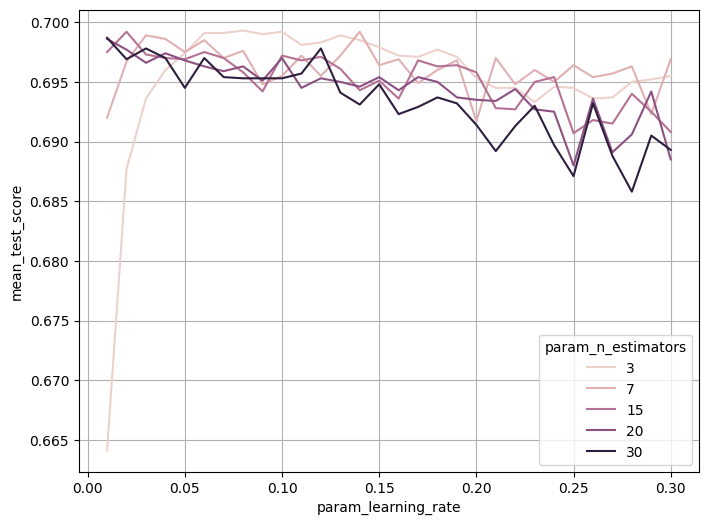

In [ ]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_learning_rate', y = 'mean_test_score', data = temp, hue = 'param_n_estimators')
plt.grid()
plt.show()